In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import mat73
import numpy as np
from tqdm import tqdm
import wandb
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

from scipy.signal import find_peaks
from sklearn.metrics import r2_score
import psutil
import os
import time

In [2]:
wandb.login()
# run = wandb.init(project="master-multicomponent-mri", name="simple-cnn-baseline-fullpatch")
run = wandb.init(project="master-multicomponent-mri", name="simple-cnn-baseline-fullpatch-improved")

wandb: Currently logged in as: tr-phan (trphan) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [ ]:
data = mat73.loadmat('../../data/training_data_T1_3D_9x9x32x47932_noise0.05.mat')
input_noisy_np = data['input_noisy']
input_clean_np = data['input']
ref_np = data['ref']

print("Shape of input data:", input_noisy_np.shape)
print("Shape of reference data:", ref_np.shape)

Shape of input data: (9, 9, 8, 47932)
Shape of reference data: (9, 9, 32, 47932)


In [4]:
nan_count_input_noisy_before = np.isnan(input_noisy_np).sum()
nan_count_ref_before = np.isnan(ref_np).sum()
print(f"NaN count in input_noisy before handling: {nan_count_input_noisy_before}")
print(f"NaN count in ref before handling: {nan_count_ref_before}")

NaN count in input_noisy before handling: 1635840
NaN count in ref before handling: 0


In [5]:
input_noisy_np = np.nan_to_num(input_noisy_np, nan=0.0)
nan_count_input_noisy_after = np.isnan(input_noisy_np).sum()
print(f"NaN count in input_noisy after handling: {nan_count_input_noisy_after}")

NaN count in input_noisy after handling: 0


In [6]:
class T1PatchDataset(Dataset):
    def __init__(self, input_data, target_data):
        self.input_data = input_data
        self.target_data = target_data

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        return self.input_data[idx], self.target_data[idx]

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(8, 64, kernel_size=3, padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.LeakyReLU(0.1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.LeakyReLU(0.1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu3 = nn.LeakyReLU(0.1)
        self.output_conv = nn.Conv2d(256, 32, kernel_size=1) # 1x1 conv for output

    def forward(self, x):
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.relu2(self.bn2(self.conv2(x)))
        x = self.relu3(self.bn3(self.conv3(x)))
        output = self.output_conv(x)
        return output

In [ ]:
class EarlyStopping:
    def __init__(self, patience=15, min_delta=1e-6, path='saved_models/best_cnn_model.pt'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.path = path
        
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.path)

In [ ]:
# Transpose the input and reference data to be (N, C, H, W) format
input_noisy_torch = np.transpose(input_noisy_np, (3, 2, 0, 1))
ref_torch = np.transpose(ref_np, (3, 2, 0, 1))

input_noisy_torch = torch.tensor(input_noisy_torch, dtype=torch.float32)
ref_torch = torch.tensor(ref_torch, dtype=torch.float32)

In [ ]:
# Create Dataset
dataset = T1PatchDataset(input_noisy_torch, ref_torch)

# Split dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)
early_stopping = EarlyStopping(patience=15, path='best_cnn_model.pt')

num_epochs = 200

d:\Proton Drive\My files\Schule\Master\Masterarbeit\project\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [12]:
# Log configuration
wandb.config.update({
    "learning_rate": 0.001,
    "batch_size": batch_size,
    "epochs": num_epochs,
    "architecture": "SimpleCNN",
    "optimizer": "Adam",
    "loss_function": "MSELoss",
    "scheduler": "ReduceLROnPlateau",
    "early_stopping_patience": 15
})

In [13]:
# Training loop
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    progress_bar_train = tqdm(train_loader, desc=f'Epoch [{epoch+1}/{num_epochs}] Training')
    
    for inputs, targets in progress_bar_train:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        train_loss += loss.item()
        progress_bar_train.set_postfix({'loss': loss.item()})

    avg_train_loss = train_loss / len(train_loader)

    # Validation phase
    model.eval()
    val_loss = 0.0
    progress_bar_val = tqdm(val_loader, desc=f'Epoch [{epoch+1}/{num_epochs}] Validation')
    
    with torch.no_grad():
        for inputs, targets in progress_bar_val:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            progress_bar_val.set_postfix({'loss': loss.item()})

    avg_val_loss = val_loss / len(val_loader)

    # Learning rate scheduling
    scheduler.step(avg_val_loss)
    current_lr = optimizer.param_groups[0]['lr']

    # Early stopping
    early_stopping(avg_val_loss, model)

    # Logging
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
        "learning_rate": current_lr
    })

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}, LR: {current_lr}')

    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

print("Training finished")

Epoch [1/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 292.18it/s, loss=0.00319]


Epoch [1/200], Train Loss: 0.004083520028507337, Val Loss: 0.0029405186713362735, LR: 0.001


Epoch [2/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 324.05it/s, loss=0.00358]


EarlyStopping counter: 1 out of 15
Epoch [2/200], Train Loss: 0.002679517214031269, Val Loss: 0.003397244292621811, LR: 0.001


Epoch [3/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 335.32it/s, loss=0.00285]


Epoch [3/200], Train Loss: 0.002565448755825249, Val Loss: 0.002616704790852964, LR: 0.001


Epoch [4/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 319.47it/s, loss=0.00287]


EarlyStopping counter: 1 out of 15
Epoch [4/200], Train Loss: 0.002475812100456096, Val Loss: 0.00263476419262588, LR: 0.001


Epoch [5/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 317.03it/s, loss=0.00272]


Epoch [5/200], Train Loss: 0.002419192226564822, Val Loss: 0.0024210363642002144, LR: 0.001


Epoch [6/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 344.32it/s, loss=0.00295]


EarlyStopping counter: 1 out of 15
Epoch [6/200], Train Loss: 0.002375267102615908, Val Loss: 0.002739598307137688, LR: 0.001


Epoch [7/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 332.29it/s, loss=0.00289]


EarlyStopping counter: 2 out of 15
Epoch [7/200], Train Loss: 0.002349695027805865, Val Loss: 0.0026488904810200134, LR: 0.001


Epoch [8/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 341.69it/s, loss=0.0026] 


EarlyStopping counter: 3 out of 15
Epoch [8/200], Train Loss: 0.0023052244548064965, Val Loss: 0.0024280382444461187, LR: 0.001


Epoch [9/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 347.76it/s, loss=0.00279]


EarlyStopping counter: 4 out of 15
Epoch [9/200], Train Loss: 0.0022751634921102473, Val Loss: 0.002432782482355833, LR: 0.001


Epoch [10/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 333.38it/s, loss=0.00282]


EarlyStopping counter: 5 out of 15
Epoch [10/200], Train Loss: 0.0022536719827136644, Val Loss: 0.002576171262189746, LR: 0.001


Epoch [11/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 324.39it/s, loss=0.00311]


EarlyStopping counter: 6 out of 15
Epoch [11/200], Train Loss: 0.0022155435098102317, Val Loss: 0.0034567540309702357, LR: 0.001


Epoch [12/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 345.79it/s, loss=0.00269]


EarlyStopping counter: 7 out of 15
Epoch [12/200], Train Loss: 0.0022003926887797813, Val Loss: 0.0025234808338185154, LR: 0.001


Epoch [13/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 331.04it/s, loss=0.00253]


Epoch [13/200], Train Loss: 0.00217681152978912, Val Loss: 0.0022540614218451082, LR: 0.001


Epoch [14/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 339.00it/s, loss=0.00302]


EarlyStopping counter: 1 out of 15
Epoch [14/200], Train Loss: 0.0021593839219228054, Val Loss: 0.002842679084278643, LR: 0.001


Epoch [15/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 339.29it/s, loss=0.00244]


Epoch [15/200], Train Loss: 0.0021624624397372826, Val Loss: 0.0021739368210546674, LR: 0.001


Epoch [16/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 339.32it/s, loss=0.00254]


EarlyStopping counter: 1 out of 15
Epoch [16/200], Train Loss: 0.002126654630410485, Val Loss: 0.0023720293825802703, LR: 0.001


Epoch [17/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 346.30it/s, loss=0.00245]


EarlyStopping counter: 2 out of 15
Epoch [17/200], Train Loss: 0.0021105703810462726, Val Loss: 0.0022066013258881865, LR: 0.001


Epoch [18/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 328.12it/s, loss=0.00268]


EarlyStopping counter: 3 out of 15
Epoch [18/200], Train Loss: 0.002095827690597313, Val Loss: 0.0024890933403124414, LR: 0.001


Epoch [19/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 339.90it/s, loss=0.00282]


EarlyStopping counter: 4 out of 15
Epoch [19/200], Train Loss: 0.002083970891738621, Val Loss: 0.0030108238213385143, LR: 0.001


Epoch [20/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 348.50it/s, loss=0.00245]


Epoch [20/200], Train Loss: 0.0020879181090276686, Val Loss: 0.002113282827970882, LR: 0.001


Epoch [21/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 223.01it/s, loss=0.00234]


Epoch [21/200], Train Loss: 0.0020635261359469343, Val Loss: 0.0020609592281592387, LR: 0.001


Epoch [22/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 316.51it/s, loss=0.00288]


EarlyStopping counter: 1 out of 15
Epoch [22/200], Train Loss: 0.0020522705940917755, Val Loss: 0.002580616396541397, LR: 0.001


Epoch [23/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 322.22it/s, loss=0.00235]


EarlyStopping counter: 2 out of 15
Epoch [23/200], Train Loss: 0.002050615565579695, Val Loss: 0.0021538015307548146, LR: 0.001


Epoch [24/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 344.13it/s, loss=0.00298]


EarlyStopping counter: 3 out of 15
Epoch [24/200], Train Loss: 0.0020385496178641914, Val Loss: 0.0025268190385152895, LR: 0.001


Epoch [25/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 328.02it/s, loss=0.00287]


EarlyStopping counter: 4 out of 15
Epoch [25/200], Train Loss: 0.0020347075573711967, Val Loss: 0.0026053318195044996, LR: 0.001


Epoch [26/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 344.72it/s, loss=0.00237]


Epoch [26/200], Train Loss: 0.002022383878356777, Val Loss: 0.0020451022832033536, LR: 0.001


Epoch [27/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 344.86it/s, loss=0.00253]


EarlyStopping counter: 1 out of 15
Epoch [27/200], Train Loss: 0.0020066593053828306, Val Loss: 0.0022219669399783015, LR: 0.001


Epoch [28/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 335.38it/s, loss=0.00248]


EarlyStopping counter: 2 out of 15
Epoch [28/200], Train Loss: 0.0020024338964140043, Val Loss: 0.0021849386394023895, LR: 0.001


Epoch [29/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 333.03it/s, loss=0.00248]


EarlyStopping counter: 3 out of 15
Epoch [29/200], Train Loss: 0.0019925826844216015, Val Loss: 0.0021507432831761736, LR: 0.001


Epoch [30/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 377.99it/s, loss=0.00236]


EarlyStopping counter: 4 out of 15
Epoch [30/200], Train Loss: 0.001987392864151237, Val Loss: 0.002059196557383984, LR: 0.001


Epoch [31/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 374.99it/s, loss=0.00234]


EarlyStopping counter: 5 out of 15
Epoch [31/200], Train Loss: 0.001983103055002478, Val Loss: 0.0020497368167464933, LR: 0.001


Epoch [32/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 388.90it/s, loss=0.00236]


EarlyStopping counter: 6 out of 15
Epoch [32/200], Train Loss: 0.0019724099988040204, Val Loss: 0.0020560624993716677, LR: 0.001


Epoch [33/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 393.42it/s, loss=0.00254]


EarlyStopping counter: 7 out of 15
Epoch [33/200], Train Loss: 0.001969761645887047, Val Loss: 0.0022808476739252606, LR: 0.001


Epoch [34/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 331.51it/s, loss=0.00249]


EarlyStopping counter: 8 out of 15
Epoch [34/200], Train Loss: 0.001962247124950712, Val Loss: 0.002048556209386637, LR: 0.001


Epoch [35/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 363.37it/s, loss=0.00268]


EarlyStopping counter: 9 out of 15
Epoch [35/200], Train Loss: 0.00195792215061374, Val Loss: 0.0023132037619749703, LR: 0.001


Epoch [36/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 395.84it/s, loss=0.00236]


EarlyStopping counter: 10 out of 15
Epoch [36/200], Train Loss: 0.0019565016054548324, Val Loss: 0.002062803339989235, LR: 0.001


Epoch [37/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 350.92it/s, loss=0.00238]


EarlyStopping counter: 11 out of 15
Epoch [37/200], Train Loss: 0.0019530927971936763, Val Loss: 0.00207067845777298, LR: 0.0005


Epoch [38/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 350.39it/s, loss=0.0022] 


Epoch [38/200], Train Loss: 0.001903211823082529, Val Loss: 0.001891138240074118, LR: 0.0005


Epoch [39/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 371.91it/s, loss=0.00226]


EarlyStopping counter: 1 out of 15
Epoch [39/200], Train Loss: 0.0019001074880361556, Val Loss: 0.0019194668050234516, LR: 0.0005


Epoch [40/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 330.04it/s, loss=0.00224]


EarlyStopping counter: 2 out of 15
Epoch [40/200], Train Loss: 0.0018958600193339711, Val Loss: 0.0019041266075025003, LR: 0.0005


Epoch [41/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 389.29it/s, loss=0.00226]


EarlyStopping counter: 3 out of 15
Epoch [41/200], Train Loss: 0.0018995269521838054, Val Loss: 0.0019238172324063877, LR: 0.0005


Epoch [42/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 348.78it/s, loss=0.00225]


EarlyStopping counter: 4 out of 15
Epoch [42/200], Train Loss: 0.0018935336830327287, Val Loss: 0.0019039560218031208, LR: 0.0005


Epoch [43/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 362.11it/s, loss=0.00226]


EarlyStopping counter: 5 out of 15
Epoch [43/200], Train Loss: 0.001889589984784834, Val Loss: 0.0019528666658637423, LR: 0.0005


Epoch [44/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 367.81it/s, loss=0.00225]


EarlyStopping counter: 6 out of 15
Epoch [44/200], Train Loss: 0.001884311772688913, Val Loss: 0.0019278530908438066, LR: 0.0005


Epoch [45/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 371.12it/s, loss=0.00226]


EarlyStopping counter: 7 out of 15
Epoch [45/200], Train Loss: 0.0018891899869777262, Val Loss: 0.0019015741379310688, LR: 0.0005


Epoch [46/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 312.80it/s, loss=0.00225]


EarlyStopping counter: 8 out of 15
Epoch [46/200], Train Loss: 0.0018926911919455354, Val Loss: 0.0019025330066991348, LR: 0.0005


Epoch [47/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 390.47it/s, loss=0.00215]


EarlyStopping counter: 9 out of 15
Epoch [47/200], Train Loss: 0.0018846989830490202, Val Loss: 0.001896353072176377, LR: 0.0005


Epoch [48/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 400.50it/s, loss=0.00225]


EarlyStopping counter: 10 out of 15
Epoch [48/200], Train Loss: 0.0018792150806014737, Val Loss: 0.0018971819834162791, LR: 0.0005


Epoch [49/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 371.86it/s, loss=0.00228]


EarlyStopping counter: 11 out of 15
Epoch [49/200], Train Loss: 0.00187632517151845, Val Loss: 0.0019085447761851052, LR: 0.00025


Epoch [50/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 354.23it/s, loss=0.00219]


Epoch [50/200], Train Loss: 0.0018527774526349578, Val Loss: 0.0018720693063611785, LR: 0.00025


Epoch [51/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 363.59it/s, loss=0.00216]


Epoch [51/200], Train Loss: 0.0018534494734679659, Val Loss: 0.001839427052376171, LR: 0.00025


Epoch [52/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 366.69it/s, loss=0.00216]


EarlyStopping counter: 1 out of 15
Epoch [52/200], Train Loss: 0.0018490821711020543, Val Loss: 0.0018467913909504812, LR: 0.00025


Epoch [53/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 363.84it/s, loss=0.00215]


EarlyStopping counter: 2 out of 15
Epoch [53/200], Train Loss: 0.0018465843154505516, Val Loss: 0.0018428661961418886, LR: 0.00025


Epoch [54/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 388.28it/s, loss=0.0022] 


EarlyStopping counter: 3 out of 15
Epoch [54/200], Train Loss: 0.0018504206793537984, Val Loss: 0.0018583044207965333, LR: 0.00025


Epoch [55/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 384.84it/s, loss=0.00218]


EarlyStopping counter: 4 out of 15
Epoch [55/200], Train Loss: 0.0018457933579338714, Val Loss: 0.0018581025263605018, LR: 0.00025


Epoch [56/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 359.98it/s, loss=0.00218]


EarlyStopping counter: 5 out of 15
Epoch [56/200], Train Loss: 0.001851587479468435, Val Loss: 0.0018599243244777123, LR: 0.00025


Epoch [57/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 373.79it/s, loss=0.00216]


EarlyStopping counter: 6 out of 15
Epoch [57/200], Train Loss: 0.0018455932873378818, Val Loss: 0.0018436412466689945, LR: 0.00025


Epoch [58/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 361.74it/s, loss=0.00219]


EarlyStopping counter: 7 out of 15
Epoch [58/200], Train Loss: 0.0018402933395312477, Val Loss: 0.0018444218393415214, LR: 0.00025


Epoch [59/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 390.55it/s, loss=0.00218]


EarlyStopping counter: 8 out of 15
Epoch [59/200], Train Loss: 0.001844345401817312, Val Loss: 0.0018461478571407497, LR: 0.00025


Epoch [60/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 365.22it/s, loss=0.00218]


EarlyStopping counter: 9 out of 15
Epoch [60/200], Train Loss: 0.0018434496734213706, Val Loss: 0.0018644834907415012, LR: 0.00025


Epoch [61/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 377.39it/s, loss=0.00217]


EarlyStopping counter: 10 out of 15
Epoch [61/200], Train Loss: 0.0018403129072006171, Val Loss: 0.0018629960777858893, LR: 0.00025


Epoch [62/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 386.00it/s, loss=0.00215]


EarlyStopping counter: 11 out of 15
Epoch [62/200], Train Loss: 0.0018396575170724343, Val Loss: 0.0018592459002199273, LR: 0.000125


Epoch [63/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 380.45it/s, loss=0.00212]


Epoch [63/200], Train Loss: 0.0018251853259668375, Val Loss: 0.0018196491291746497, LR: 0.000125


Epoch [64/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 370.24it/s, loss=0.00213]


EarlyStopping counter: 1 out of 15
Epoch [64/200], Train Loss: 0.0018282564851688221, Val Loss: 0.0018465401177915435, LR: 0.000125


Epoch [65/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 372.65it/s, loss=0.00215]


EarlyStopping counter: 2 out of 15
Epoch [65/200], Train Loss: 0.0018220599606866017, Val Loss: 0.0018281952276205022, LR: 0.000125


Epoch [66/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 377.02it/s, loss=0.00213]


EarlyStopping counter: 3 out of 15
Epoch [66/200], Train Loss: 0.0018217241473030298, Val Loss: 0.0018250387612109382, LR: 0.000125


Epoch [67/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 365.32it/s, loss=0.00212]


Epoch [67/200], Train Loss: 0.00182222283561714, Val Loss: 0.0018182120596369107, LR: 0.000125


Epoch [68/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 382.73it/s, loss=0.00213]


EarlyStopping counter: 1 out of 15
Epoch [68/200], Train Loss: 0.0018227566865971312, Val Loss: 0.0018299368435206512, LR: 0.000125


Epoch [69/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 390.94it/s, loss=0.00213]


Epoch [69/200], Train Loss: 0.001823139017020973, Val Loss: 0.0018134386333016057, LR: 0.000125


Epoch [70/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 377.19it/s, loss=0.00215]


EarlyStopping counter: 1 out of 15
Epoch [70/200], Train Loss: 0.0018195005768211559, Val Loss: 0.0018266242370009423, LR: 0.000125


Epoch [71/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 365.49it/s, loss=0.00213]


EarlyStopping counter: 2 out of 15
Epoch [71/200], Train Loss: 0.0018228554273567474, Val Loss: 0.001853970334244271, LR: 0.000125


Epoch [72/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 359.17it/s, loss=0.00215]


EarlyStopping counter: 3 out of 15
Epoch [72/200], Train Loss: 0.0018197740336957698, Val Loss: 0.001819607784661154, LR: 0.000125


Epoch [73/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 392.53it/s, loss=0.00214]


EarlyStopping counter: 4 out of 15
Epoch [73/200], Train Loss: 0.0018217524932697415, Val Loss: 0.0018253773194737732, LR: 0.000125


Epoch [74/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 394.09it/s, loss=0.00215]


EarlyStopping counter: 5 out of 15
Epoch [74/200], Train Loss: 0.001818149228929542, Val Loss: 0.0018219670684387287, LR: 0.000125


Epoch [75/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 392.40it/s, loss=0.00212]


EarlyStopping counter: 6 out of 15
Epoch [75/200], Train Loss: 0.0018188854770657297, Val Loss: 0.0018191879040872058, LR: 0.000125


Epoch [76/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 355.24it/s, loss=0.00213]


EarlyStopping counter: 7 out of 15
Epoch [76/200], Train Loss: 0.0018160334988109145, Val Loss: 0.0018168695193404953, LR: 0.000125


Epoch [77/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 385.97it/s, loss=0.00216]


EarlyStopping counter: 8 out of 15
Epoch [77/200], Train Loss: 0.0018161268130643293, Val Loss: 0.0018202648133349916, LR: 0.000125


Epoch [78/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 387.37it/s, loss=0.00219]


EarlyStopping counter: 9 out of 15
Epoch [78/200], Train Loss: 0.0018189986172365024, Val Loss: 0.001880437523747484, LR: 0.000125


Epoch [79/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 374.69it/s, loss=0.00212]


EarlyStopping counter: 10 out of 15
Epoch [79/200], Train Loss: 0.0018182046280708164, Val Loss: 0.0018127210244225959, LR: 0.000125


Epoch [80/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 355.90it/s, loss=0.00213]


EarlyStopping counter: 11 out of 15
Epoch [80/200], Train Loss: 0.001817388353132022, Val Loss: 0.0018297278283474347, LR: 0.000125


Epoch [81/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 385.34it/s, loss=0.00219]


EarlyStopping counter: 12 out of 15
Epoch [81/200], Train Loss: 0.001818854781643798, Val Loss: 0.0018518931853274505, LR: 0.000125


Epoch [82/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 388.25it/s, loss=0.00215]


EarlyStopping counter: 13 out of 15
Epoch [82/200], Train Loss: 0.0018165272918607418, Val Loss: 0.0018191704511021575, LR: 0.000125


Epoch [83/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 354.91it/s, loss=0.0021] 


EarlyStopping counter: 14 out of 15
Epoch [83/200], Train Loss: 0.0018143738804307457, Val Loss: 0.0018199492051887015, LR: 0.000125


Epoch [84/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 390.62it/s, loss=0.00213]

EarlyStopping counter: 15 out of 15
Epoch [84/200], Train Loss: 0.0018142314782987037, Val Loss: 0.0018192585837095976, LR: 0.000125
Early stopping triggered
Training finished


In [ ]:
def calculate_psnr(target, prediction):
    """Calculate Peak Signal-to-Noise Ratio"""
    mse = np.mean((target - prediction) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = np.max(target)
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

def calculate_peak_metrics_patch(target, prediction, prominence=0.1):
    """Calculate peak detection accuracy for full patch predictions"""
    peak_metrics = {'true_peaks': 0, 'predicted_peaks': 0, 'matching_peaks': 0}
    
    # Iterate over each voxel in the patch
    batch_size, num_points, height, width = target.shape
    
    for b in range(batch_size):
        for h in range(height):
            for w in range(width):
                # Get spectrum for current voxel
                true_spectrum = target[b, :, h, w]
                pred_spectrum = prediction[b, :, h, w]
                
                # Find peaks
                true_peaks, _ = find_peaks(true_spectrum, prominence=prominence)
                pred_peaks, _ = find_peaks(pred_spectrum, prominence=prominence)
                
                # Count matching peaks
                matches = 0
                for tp in true_peaks:
                    for pp in pred_peaks:
                        if abs(tp - pp) <= 1:
                            matches += 1
                            break
                
                peak_metrics['true_peaks'] += len(true_peaks)
                peak_metrics['predicted_peaks'] += len(pred_peaks)
                peak_metrics['matching_peaks'] += matches
    
    return peak_metrics

def measure_inference_time(model, input_tensor, device, num_iterations=100):
    """Measure average inference time"""
    model.eval()
    start_time = time.time()
    with torch.no_grad():
        for _ in range(num_iterations):
            _ = model(input_tensor.to(device))
    end_time = time.time()
    return (end_time - start_time) / num_iterations

def count_parameters(model):
    """Count number of trainable parameters"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def measure_memory_usage():
    """Measure current memory usage"""
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024  # Convert to MB

def calculate_spatial_consistency(targets, predictions, window_size=3):
    """Calculate spatial consistency metric with proper handling of constant patches"""
    batch_size, num_points, height, width = targets.shape
    consistency_scores = []
    
    # Calculate local spatial correlation for each patch
    for b in range(min(batch_size, 100)):  # Limit to 100 samples for efficiency
        for t in range(num_points):
            true_patch = targets[b, t]
            pred_patch = predictions[b, t]
            
            # Skip if either patch is constant
            if np.std(true_patch) == 0 or np.std(pred_patch) == 0:
                continue
                
            # Calculate local spatial correlation
            try:
                correlation = np.corrcoef(true_patch.flatten(), pred_patch.flatten())[0, 1]
                if not np.isnan(correlation):
                    consistency_scores.append(correlation)
            except:
                continue
    
    # Return mean if we have scores, otherwise return 0
    return np.mean(consistency_scores) if consistency_scores else 0.0


def evaluate_model_metrics(model, val_loader, device):
    """Evaluate all model metrics for patch-based models"""
    model.eval()
    metrics = {}
    
    # Get sample input for inference time measurement
    sample_input, _ = next(iter(val_loader))
    metrics['inference_time'] = measure_inference_time(model, sample_input, device)
    
    all_targets = []
    all_predictions = []
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            
            # Convert to numpy for metric calculation
            targets_np = targets.cpu().numpy()
            outputs_np = outputs.cpu().numpy()
            
            all_targets.append(targets_np)
            all_predictions.append(outputs_np)
    
    # Concatenate all batches
    all_targets = np.concatenate(all_targets)
    all_predictions = np.concatenate(all_predictions)
    
    # Calculate metrics
    metrics['mse'] = np.mean((all_targets - all_predictions) ** 2)
    metrics['mae'] = np.mean(np.abs(all_targets - all_predictions))
    metrics['psnr'] = calculate_psnr(all_targets, all_predictions)
    
    # Calculate R² score for each spatial position
    r2_scores = []
    batch_size, num_points, height, width = all_targets.shape
    for h in range(height):
        for w in range(width):
            true_spectra = all_targets[:, :, h, w].reshape(-1)
            pred_spectra = all_predictions[:, :, h, w].reshape(-1)
            r2_scores.append(r2_score(true_spectra, pred_spectra))
    metrics['r2_score'] = np.mean(r2_scores)
    
    # Calculate peak metrics for patches
    metrics['peak_metrics'] = calculate_peak_metrics_patch(all_targets, all_predictions)
    
    # System metrics
    metrics['memory_usage'] = measure_memory_usage()
    metrics['num_parameters'] = count_parameters(model)
    
    # Add spatial metrics
    metrics['spatial_consistency'] = calculate_spatial_consistency(all_targets, all_predictions)
    
    return metrics

In [ ]:
model.eval()
final_metrics = evaluate_model_metrics(model, val_loader, device)

wandb.log({
    "final_mse": final_metrics['mse'],
    "final_mae": final_metrics['mae'],
    "final_psnr": final_metrics['psnr'],
    "final_r2_score": final_metrics['r2_score'],
    "peak_detection_accuracy": final_metrics['peak_metrics']['matching_peaks'] / 
                             final_metrics['peak_metrics']['true_peaks'],
    "inference_time_ms": final_metrics['inference_time'] * 1000,
    "memory_usage_mb": final_metrics['memory_usage'],
    "model_parameters": final_metrics['num_parameters']
})

print("\nFinal Model Evaluation:")
print(f"MSE: {final_metrics['mse']:.6f}")
print(f"MAE: {final_metrics['mae']:.6f}")
print(f"PSNR: {final_metrics['psnr']:.2f} dB")
print(f"R² Score: {final_metrics['r2_score']:.4f}")
print(f"Peak Detection Accuracy: {final_metrics['peak_metrics']['matching_peaks'] / final_metrics['peak_metrics']['true_peaks']:.2%}")
print(f"Average Inference Time: {final_metrics['inference_time']*1000:.2f} ms")
print(f"Memory Usage: {final_metrics['memory_usage']:.1f} MB")
print(f"Number of Parameters: {final_metrics['num_parameters']:,}")


Final Model Evaluation:
MSE: 0.001819
MAE: 0.022686
PSNR: 27.39 dB
R² Score: 0.5555
Peak Detection Accuracy: 40.80%
Average Inference Time: 0.99 ms
Memory Usage: 2705.1 MB
Number of Parameters: 382,816


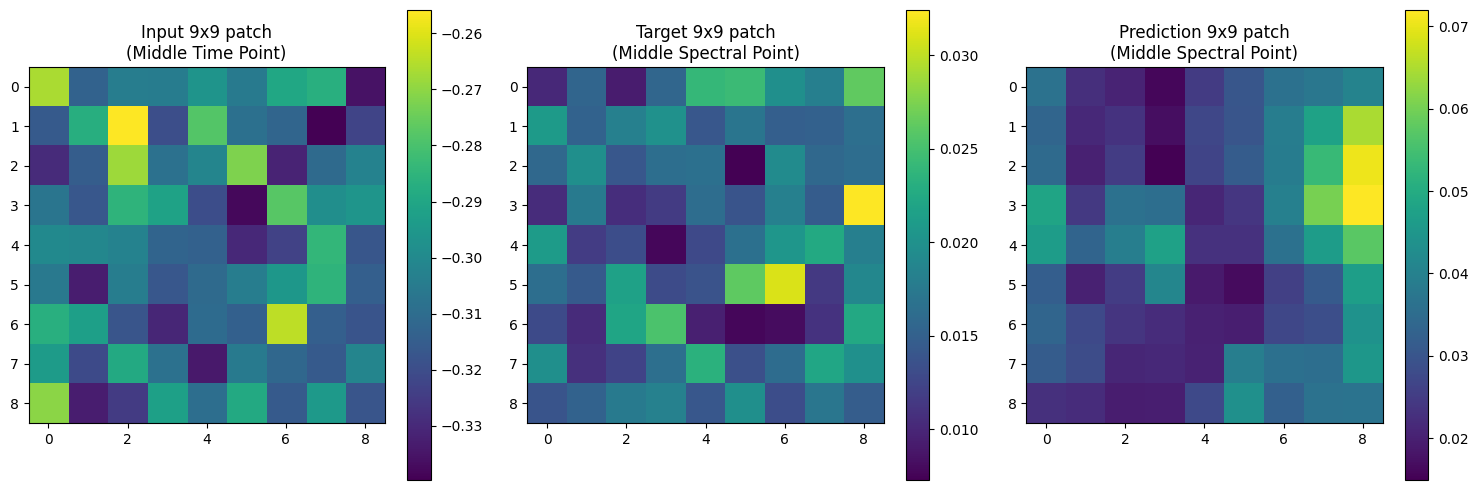

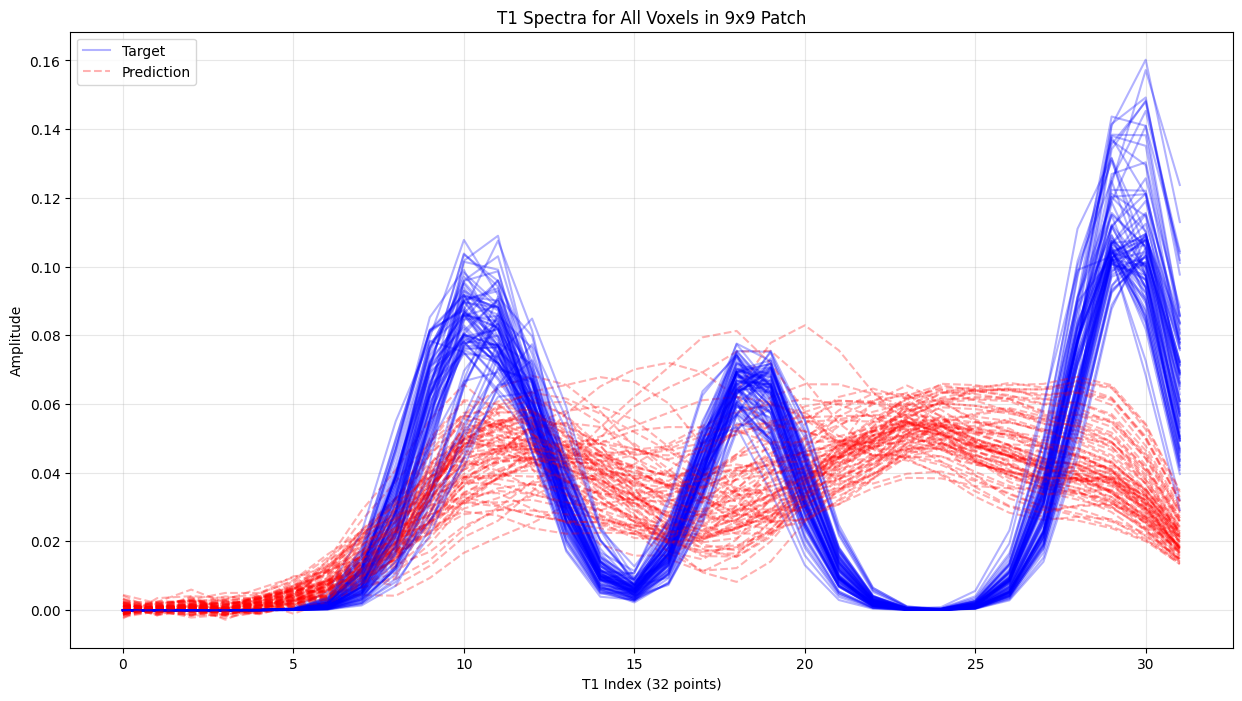

Full 9x9 patch MSE: 0.001178
Full 9x9 patch MAE: 0.026096

Mean Voxel MSE: 0.001178
Std Voxel MSE: 0.000212
Min Voxel MSE: 0.000812
Max Voxel MSE: 0.002102


In [ ]:
inputs, targets = next(iter(val_loader))
inputs, targets = inputs.to(device), targets.to(device)

with torch.no_grad():
    outputs = model(inputs)

inputs = inputs.cpu().numpy()
targets = targets.cpu().numpy()
outputs = outputs.cpu().numpy()

example_idx = 0

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(inputs[example_idx, 4, :, :])  # Middle temporal slice (4 out of 8)
plt.title('Input 9x9 patch\n(Middle Time Point)')
plt.colorbar()

plt.subplot(132)
plt.imshow(targets[example_idx, 16, :, :])  # Middle spectral point (16 out of 32)
plt.title('Target 9x9 patch\n(Middle Spectral Point)')
plt.colorbar()

plt.subplot(133)
plt.imshow(outputs[example_idx, 16, :, :])  # Middle spectral point
plt.title('Prediction 9x9 patch\n(Middle Spectral Point)')
plt.colorbar()

plt.tight_layout()
plt.show()

# Plot all 81 voxels (9x9) in a single plot
plt.figure(figsize=(15, 8))

for i in range(9):
    for j in range(9):
        plt.plot(targets[example_idx, :, i, j], 'b-', alpha=0.3, label='Target' if i==0 and j==0 else "")
        plt.plot(outputs[example_idx, :, i, j], 'r--', alpha=0.3, label='Prediction' if i==0 and j==0 else "")

plt.title('T1 Spectra for All Voxels in 9x9 Patch')
plt.xlabel('T1 Index (32 points)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print metrics for the whole 9x9 patch
patch_mse = np.mean((targets[example_idx] - outputs[example_idx])**2)
patch_mae = np.mean(np.abs(targets[example_idx] - outputs[example_idx]))
print(f"Full 9x9 patch MSE: {patch_mse:.6f}")
print(f"Full 9x9 patch MAE: {patch_mae:.6f}")

# Calculate statistics of individual voxel MSEs
voxel_mses = []
for i in range(9):
    for j in range(9):
        mse = np.mean((targets[example_idx, :, i, j] - outputs[example_idx, :, i, j])**2)
        voxel_mses.append(mse)

print(f"\nMean Voxel MSE: {np.mean(voxel_mses):.6f}")
print(f"Std Voxel MSE: {np.std(voxel_mses):.6f}")
print(f"Min Voxel MSE: {np.min(voxel_mses):.6f}")
print(f"Max Voxel MSE: {np.max(voxel_mses):.6f}")

In [17]:
wandb.finish()

epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
final_mae,▁
final_mse,▁
final_psnr,▁
final_r2_score,▁
inference_time_ms,▁
learning_rate,███████████████▄▄▄▄▄▄▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
memory_usage_mb,▁
model_parameters,▁
peak_detection_accuracy,▁
train_loss,█▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
